# Day 2 — Review Classification (Sentiment)

Goal: predict sentiment (**negative / neutral / positive**) from review text.

Plan:
1) Baseline model (TF-IDF + Logistic Regression)
2) Transformer model (DistilBERT)
3) Compare results + save artifacts for the report/PPT

## Load the processed train/test splits

We’ll use the cleaned files created in Day 1:
- `data/processed/train.csv`
- `data/processed/test.csv`

In [1]:
import pandas as pd

train_df = pd.read_csv("../data/processed/train.csv")
test_df  = pd.read_csv("../data/processed/test.csv")

print("train:", train_df.shape)
print("test: ", test_df.shape)

print("\nLabel counts (train):")
print(train_df["label"].value_counts())

train_df[["label", "text"]].head(3)

train: (27700, 7)
test:  (6926, 7)

Label counts (train):
label
positive    25851
neutral      1199
negative      650
Name: count, dtype: int64


,label,text
0,positive,We like the Fire better than Roku. We also pre...
1,positive,So far no problems except no kid friendly case...
2,positive,A decent tablet. Just wish the app store had s...


## Baseline: TF-IDF + Logistic Regression

- fast to train
- easy to interpret
- gives us a solid benchmark before using Transformers

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

baseline = Pipeline([
    ("tfidf", TfidfVectorizer(
        max_features=50_000,
        ngram_range=(1, 2),
        min_df=2,
        stop_words="english"
    )),
    ("clf", LogisticRegression(
        max_iter=2500,
        n_jobs=-1,
        class_weight="balanced"
    ))
])

baseline.fit(train_df["text"], train_df["label"])
print("Baseline trained.")

/home/lopoa/projects/automated-customer-reviews/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1184: FutureWarning: 'n_jobs' has no effect since 1.8 and will be removed in 1.10. You provided 'n_jobs=-1', please leave it unspecified.
  warnings.warn(msg, category=FutureWarning)


Baseline trained.


## Baseline evaluation

Report:
- precision / recall / F1 per class
- overall accuracy
- confusion matrix (for the writeup + slides)

Accuracy: 0.8796

Classification report:

              precision    recall  f1-score   support

    negative      0.323     0.506     0.394       162
     neutral      0.192     0.370     0.253       300
    positive      0.968     0.913     0.939      6464

    accuracy                          0.880      6926
   macro avg      0.494     0.596     0.529      6926
weighted avg      0.919     0.880     0.897      6926



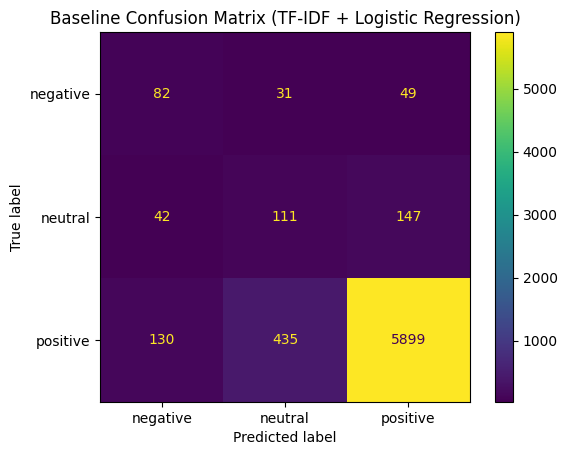

In [3]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import matplotlib.pyplot as plt

LABEL_ORDER = ["negative", "neutral", "positive"]

pred_base = baseline.predict(test_df["text"])

print("Accuracy:", round(accuracy_score(test_df["label"], pred_base), 4))
print("\nClassification report:\n")
print(classification_report(test_df["label"], pred_base, digits=3))

cm = confusion_matrix(test_df["label"], pred_base, labels=LABEL_ORDER)
disp = ConfusionMatrixDisplay(cm, display_labels=LABEL_ORDER)

disp.plot(values_format="d")
plt.title("Baseline Confusion Matrix (TF-IDF + Logistic Regression)")
plt.show()

## Save baseline artifacts

This saves a confusion matrix image + a text report.
Drop into:
- the PDF report
- the PPT

In [4]:
from pathlib import Path
import matplotlib.pyplot as plt

out_dir = Path("../reports/artifacts")
out_dir.mkdir(parents=True, exist_ok=True)

# Save confusion matrix figure
fig = disp.figure_
fig.savefig(out_dir / "baseline_confusion_matrix.png", dpi=200, bbox_inches="tight")
plt.close(fig)

# Save classification report text
report_txt = classification_report(test_df["label"], pred_base, digits=3)
with open(out_dir / "baseline_classification_report.txt", "w") as f:
    f.write("Baseline (TF-IDF + Logistic Regression)\n")
    f.write(f"Accuracy: {accuracy_score(test_df['label'], pred_base):.4f}\n\n")
    f.write(report_txt)

print("Saved artifacts to:", out_dir.resolve())

Saved artifacts to: /home/lopoa/projects/automated-customer-reviews/reports/artifacts


## Transformer: DistilBERT fine-tuning (GPU)

We’ll fine-tune DistilBERT for multi-class sentiment classification.

Notes:
- 1–2 epochs is enough for the demo.
- We cap max_length to keep training fast.

In [5]:
import torch
from datasets import Dataset
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    DataCollatorWithPadding, TrainingArguments, Trainer
)
import numpy as np
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

print("CUDA available:", torch.cuda.is_available())

CUDA available: True


## Prepare datasets + label encoding

Transformers need numeric labels, so we map:
- negative → 0
- neutral → 1
- positive → 2

In [6]:
LABEL2ID = {"negative": 0, "neutral": 1, "positive": 2}
ID2LABEL = {v: k for k, v in LABEL2ID.items()}

train_small = train_df[["text", "label"]].copy()
test_small  = test_df[["text", "label"]].copy()

train_small["label_id"] = train_small["label"].map(LABEL2ID)
test_small["label_id"]  = test_small["label"].map(LABEL2ID)

ds_train = Dataset.from_pandas(train_small[["text", "label_id"]])
ds_test  = Dataset.from_pandas(test_small[["text", "label_id"]])

MODEL_NAME = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def tokenize(batch):
    return tokenizer(batch["text"], truncation=True, max_length=192)

ds_train = ds_train.map(tokenize, batched=True, remove_columns=["text"])
ds_test  = ds_test.map(tokenize, batched=True, remove_columns=["text"])

ds_train = ds_train.rename_column("label_id", "labels")
ds_test  = ds_test.rename_column("label_id", "labels")

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Map:   0%|          | 0/27700 [00:00<?, ? examples/s]

Map:   0%|          | 0/6926 [00:00<?, ? examples/s]

## Train the transformer

- starting with **1 epoch**
- only increase to 2 if it runs smoothly

In [7]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    p, r, f1, _ = precision_recall_fscore_support(labels, preds, average="weighted", zero_division=0)
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "precision_w": p, "recall_w": r, "f1_w": f1}

model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=3,
    id2label=ID2LABEL,
    label2id=LABEL2ID
)

args = TrainingArguments(
    output_dir="../reports/artifacts/distilbert_runs",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="steps",
    logging_steps=50,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=2,
    learning_rate=2e-5,
    weight_decay=0.01,
    fp16=torch.cuda.is_available(),
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=ds_train,
    eval_dataset=ds_test,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

trainer.train()

Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

DistilBertForSequenceClassification LOAD REPORT from: distilbert-base-uncased
Key                     | Status     | 
------------------------+------------+-
vocab_transform.bias    | UNEXPECTED | 
vocab_transform.weight  | UNEXPECTED | 
vocab_layer_norm.weight | UNEXPECTED | 
vocab_layer_norm.bias   | UNEXPECTED | 
vocab_projector.bias    | UNEXPECTED | 
pre_classifier.weight   | MISSING    | 
classifier.weight       | MISSING    | 
classifier.bias         | MISSING    | 
pre_classifier.bias     | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


Epoch,Training Loss,Validation Loss,Accuracy,Precision W,Recall W,F1 W
1,0.202460,0.189345,0.939936,0.921680,0.939936,0.925118
2,0.145458,0.193132,0.944124,0.931416,0.944124,0.936087


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

TrainOutput(global_step=3464, training_loss=0.18094289660729107, metrics={'train_runtime': 70.2294, 'train_samples_per_second': 788.843, 'train_steps_per_second': 49.324, 'total_flos': 1650124067075568.0, 'train_loss': 0.18094289660729107, 'epoch': 2.0})

## Evaluate transformer + save artifacts

We’ll save:
- metrics summary (txt)
- confusion matrix (png)

Metrics saved → ../reports/artifacts/distilbert_metrics.txt


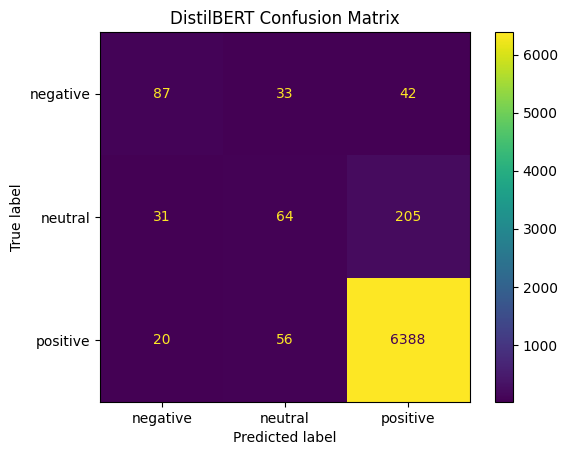

Confusion matrix saved → ../reports/artifacts/distilbert_confusion_matrix.png


In [8]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay

out_dir = Path("../reports/artifacts")
out_dir.mkdir(parents=True, exist_ok=True)

pred = trainer.predict(ds_test)
y_pred = np.argmax(pred.predictions, axis=1)
y_true = test_small["label_id"].to_numpy()

acc = accuracy_score(y_true, y_pred)
p, r, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted", zero_division=0)

metrics_path = out_dir / "distilbert_metrics.txt"
with open(metrics_path, "w") as f:
    f.write("DistilBERT (weighted)\n")
    f.write(f"Accuracy:  {acc:.4f}\n")
    f.write(f"Precision: {p:.4f}\n")
    f.write(f"Recall:    {r:.4f}\n")
    f.write(f"F1:        {f1:.4f}\n")

print(f"Metrics saved → {metrics_path}")

labels = ["negative", "neutral", "positive"]
cm = confusion_matrix(y_true, y_pred, labels=[0, 1, 2])

disp = ConfusionMatrixDisplay(cm, display_labels=labels)
disp.plot(values_format="d")
plt.title("DistilBERT Confusion Matrix")

cm_path = out_dir / "distilbert_confusion_matrix.png"
plt.savefig(cm_path, dpi=200, bbox_inches="tight")
plt.show()

print(f"Confusion matrix saved → {cm_path}")

In [9]:
from pathlib import Path
import numpy as np

df = test_df[["text", "label"]].copy()
df["pred_label"] = y_pred
df["pred_confidence"] = np.max(y_proba, axis=1) if "y_proba" in globals() and y_proba is not None else np.nan

out_path = Path("../data/processed/test_labeled.csv")
out_path.parent.mkdir(parents=True, exist_ok=True)
df.to_csv(out_path, index=False)

out_path

PosixPath('../data/processed/test_labeled.csv')

## Export final model for the demo app

In [10]:
from pathlib import Path
from transformers import AutoTokenizer, AutoModelForSequenceClassification

CKPT_DIR = Path("../reports/artifacts/distilbert_runs/checkpoint-3464")
OUT_DIR  = Path("../models/distilbert_sentiment")

if not CKPT_DIR.exists():
    raise FileNotFoundError(f"Checkpoint not found: {CKPT_DIR.resolve()}")

OUT_DIR.mkdir(parents=True, exist_ok=True)

tokenizer = AutoTokenizer.from_pretrained(CKPT_DIR)
model = AutoModelForSequenceClassification.from_pretrained(CKPT_DIR)

tokenizer.save_pretrained(OUT_DIR)
model.save_pretrained(OUT_DIR)

print("Exported to:", OUT_DIR.resolve())
print("Files:", sorted(p.name for p in OUT_DIR.iterdir()))

Loading weights:   0%|          | 0/104 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Exported to: /home/lopoa/projects/automated-customer-reviews/models/distilbert_sentiment
Files: ['config.json', 'model.safetensors', 'tokenizer.json', 'tokenizer_config.json']
